# Datos de Movilidad
## Estimado de viajes diarios entre municipios y alcaldías de la Zona Metropolitana del Valle de México (ZMVM)



La Encuesta Origen y Destino del INEGI proporciona datos sobre el número de viajes realizados entre un par de distritos de la ZMVM en un día entre semana, i.e. el número reportado es viajes por día, o en un sábado. Para usar estos datos en nuestro modelo debemos estimar el número de viajes que se harían en un domingo entre un par de distritos.

Necesitamos solucionar dos problemas: encontrar el número de viajes entre dos municipios --- no entre distritos --- y estimar la cantidad de viajes para los domingos. Esto lo solucionamos de la siguiente manera:

Definimos tres funciones:

- `limpiezaMatrizMovilidad`: Obtiene la matriz de movilidad entre distritos de la ZMVM a partir de uno de  dos artchivos csv: uno tiene la información para los viajes entre semana y en sabado (esto último es el parámetro 'tipo de viaje'). Regresa un `pd.DataFrame` donde los nombres de las columnas y los registros de la columna 'origen' son los códigos de los distritos de la ZMVM.


- `distritosAPares`: toma el `pd.DataFrame` generado en la función anterior y cambia el código de distrito por su par de estado/municipio. Agrupa y suma para municipios repetidos.


- `paresANombres`: toma el `pd.DataFrame` generado en la función anterior y cambia el par estado/municipio por el nombre del municipio.

que resuleven el primero de nuestros problemas.

In [75]:
import pandas as pd
import pickle
import numpy as np

In [2]:
def limpiezaMatrizMovilidad(tipo_de_viaje):
    """Obtiene la matriz de movilidad entre distritos de la ZMVM a partir de uno de  dos artchivos csv: uno tiene la 
    información para los viajes entre semana y en sabado (esto último es el parámetro 'tipo de viaje'). 
    
    Args:
        tipo_de_viajes(str): 'entre_semana' o 'sabado'.
        
    Returns:
        pd.DataFrame: donde los nombres de las columnas y los registros de la columna 'origen' son los códigos de los
        distritos de la ZMVM."""
    # los nombres de ambos archivos inician de la misma forma
    nombre_archivo = "rawdata/tabulados_eod_2017_" + tipo_de_viaje + ".xlsx"
    try:
        hoja = ""
        if tipo_de_viaje == 'sabado':
            hoja = 'Matriz_OD_9.1'
        else: 
            hoja = 'Matriz_OD_8.1'
        # leemos el archivo excel correspondiente
        excel = pd.read_excel(nombre_archivo, sheet_name = hoja, keep_default_na = False)
    except:
        return
    # los datos en renglones empiezan desde el renglón 8 y terminan en el 194 (los distritos con nombre asignado.)
    excel = excel.iloc[8:194+8].reset_index(drop=True)
    # renombro la primer columna. Tiene un nombre feo --- que es el título
    nombre_feo = "INEGI. Encuesta Origen-Destino en Hogares de la Zona Metropolitana del Valle de México 2017 (EOD). Viajes "
    if tipo_de_viaje == 'sabado':
        nombre_feo += "en sábado" + ". Tabulados"
    else:
        nombre_feo += "entre semana" + ". Tabulados"
    excel.rename(columns = {nombre_feo:"origen"}, inplace = True)
    # obtenemos las claves de los distritos
    dist_names = {}
    for i, destino in enumerate(excel.iloc[:, 0]):
        # queremos solo el código
        dist_names["Unnamed: {}".format(i+2)] = int(destino[:3])
    # cambiamos el nombre del distrito por su clave 1-300
    excel.rename(columns = dist_names, inplace = True)
    # borramos la columna unnamed 1: que es los viajes del origen a la ZMVM y las dos últimas columnas que son depósitos
    excel.drop(columns = ["Unnamed: 1", "Unnamed: 196", "Unnamed: 197"], inplace = True)
    # en origen solo usamos los códigos de los distritos
    excel['origen'] = excel['origen'].apply(lambda x: int(x[0:3]))
    # regresamos la matriz de viajes con códigos de los distritos
    return excel

In [3]:
def distritosAPares(matrizMovilidadDistritos):
    """Mapea el código de los distritos en la matriz de Movilidad por distritos a un par (i, j) donde i es el código del 
    estado y j es el código del municipio.
    
    Args: 
        matrizMovilidadDistritos(pd.DataFrame): el resultado de la función limpiezaMatrizMovilidad."""
    # leemos el diccionario de los distritos.
    with open('rawdata/distritos.pkl', 'rb') as handle:
        distritos = pickle.load(handle)
    # cambiamos los códigos de los distritos por los pares de estado, municipio (en código)
    copy = matrizMovilidadDistritos.rename(columns = distritos)
    # agrupamos por columna, pues hay municipios que se repiten
    copy = copy.groupby(level = 0, axis = 1).sum()
    # cambiamos la columna origen
    copy['origen'] = copy['origen'].apply(lambda x: distritos[x])
    # agrupamos filas por los municipios
    copy = copy.groupby(by = 'origen').sum()
    return copy

In [4]:
def paresANombres(matrizMovilidad):
    # leemos el diccionario de los municipios.
    with open('rawdata/municipios.pkl', 'rb') as handle:
        municipios = pickle.load(handle)
    # cambiamos el index de municipios
    mun = municipios.set_index(['estado', 'municipio'])
    copy = matrizMovilidad.copy() # hacemos la copia
    indicesfil = [] # indices pa las filas
    # ------- aquí podriamos obtener el archivo pkl para los pares de los municipios en la ZMVM
    #with open('rawdata/paresZMVM.pkl', 'wb') as handle:
        #pickle.dump(copy.index.tolist(), handle, protocol=pickle.HIGHEST_PROTOCOL)
    # ----------------------------------------------------------------------------------------
    for i, ind in enumerate(copy.index):
        indicesfil.append(mun.loc[ind, 'nombre'])
    # cambiamos el nombre de los indices
    copy.index = indicesfil
    indicescol = [] # indices para las columnas
    for i, ind in enumerate(copy.columns):
        indicescol.append(mun.loc[ind, 'nombre'])
    # cambiamos el nombre de las columnas
    copy.columns = indicescol
    return copy

In [5]:
# función extra
# ya no hay que correrla
# es para generar los pares de los distritos
def obtenerDistritosAPares():
    """Genera un diccionario donde a cada distrito le asigna su par: código estado, código municipio."""
    # leemos el archivo que tiene las respuestas de la encuesta Origen Destino.
    # este archivo es muy grande para github. Solo lo corrí en local
    encuesta = pd.read_csv('rawdata/tviaje.csv')
    # obtenemos las respuestas para viajes que son de la cdmx, del edomex y hgo
    # la pregunta 'p5_7_7' tiene el código del estado de origen
    encuesta = encuesta[encuesta["p5_7_7"].isin([9, 15, 13])]
    # queremos los datos del municipio de origen: p5_7_6, estado de origen: p5_7_7, distrito de origen: dto_origen
    # municipio de destino: p5_12_6, estado de destino: p5_12_7, distrito de destino: dto_dest
    encuesta = encuesta[["p5_7_6", "p5_7_7", "dto_origen", "p5_12_6", "p5_12_7", "dto_dest"]]
    # cambiamos los nombres para que esté más cool. Nos da más info que solo el código de la pregunta
    encuesta = encuesta.rename(columns = {"p5_7_6":"mun_origen", "p5_7_7":"est_origen", "p5_12_6":"mun_dest",
                                                 "p5_12_7":"est_dest"})
    # hacemos un multi index
    encuesta.set_index(['dto_origen', 'est_origen', 'mun_origen'], inplace = True)
    # con esto ya podemos mapear
    distritos = {}
    for i in encuesta.index:
        # i es una tupla: la primer entrada es el distrito, la segunda el estado y el tercero el municipio
        if i[0] not in distritos and i[2] < 130:
            distritos[i[0]] = i[1:]
    # generamos el archivo binario con el objeto 
    with open('rawdata/distritos.pkl', 'wb') as handle:
        pickle.dump(distritos, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
#obtenerDistritosAPares()

In [8]:
# función extra
# ya no hay que correrla
def obtenerParesANombres():
    """Obtiene un archivo pikle con los nombres de los  municipios con su código y el código del estado."""
    df = pd.read_csv("rawdata\Casos_Diarios_Municipio_Confirmados_20230226.csv", encoding = 'utf-8', 
                          dtype = {'cve_ent':str, 'nombre':str}, usecols = [0, 2])

    df["estado"] = df.cve_ent.apply(lambda x: x[:2])
    df["municipio"] = df.cve_ent.apply(lambda x: x[2:])

    df = df[df["estado"].isin(["15", "09", "13"])] 
                                   
    df["estado"] = df["estado"].astype(int)
    df["municipio"] = df["municipio"].astype(int)
                                   
     # generamos el archivo binario con el objeto 
    with open('rawdata/municipios.pkl', 'wb') as handle:
        pickle.dump(df[['estado', 'municipio', 'nombre']], handle, protocol=pickle.HIGHEST_PROTOCOL) 

In [9]:
#obtenerParesANombres()

El portal de Datos Abiertos del Gobierno de la CDMX reporta el estimado de viajes en el STC Metro. Para estimar los viajes en domingo, vamos a ver cómo se comportan los viajes en domingo respecto a los del sábado en el año 2017 en toda la línea:

In [42]:
viajes_metro = pd.read_csv('rawdata/afluenciastc_simple_02_2023.csv', encoding = 'latin')
viajes_metro = viajes_metro[viajes_metro.anio == 2017]

In [43]:
viajes_metro = viajes_metro.groupby('fecha')[['afluencia']].sum()

In [47]:
viajes_metro['dia'] = pd.to_datetime(viajes_metro.index, yearfirst = True).day_name()

In [49]:
viajes_metro = viajes_metro[viajes_metro.dia.isin(['Sunday', 'Saturday'])]

Vamos a suponer que el número de viajes en domingo es proporcional al número de viajes en sábado. Para encontrar esta constante usamos `curve_fit` para ajustar este modelo:

In [57]:
from scipy.optimize import curve_fit

In [61]:
x = viajes_metro[viajes_metro.dia == 'Saturday'].afluencia
y = viajes_metro[viajes_metro.dia == 'Sunday'].afluencia.iloc[:-1] # hay un domingo de más
# ajustamos
a = curve_fit(lambda x, a: a*x, x, y)[0]

In [62]:
a

array([0.62288648])

El valor estimado es `a = 0.6229`. Una vez que obtengamos la matriz de viajes de la EOD para los días sábados, vamos a obtener la matriz para los domingos multiplicando el valor de la entrada $a_{ij}$ de la matriz anterior por mnuestra constante `a`.

## Matriz final

Vamos a generar un dataframe con los datos para los tres tipos de días de la semana (entre semana, sábado, domingo), donde las primeras $n$ columnas --- $n$ siendo el número de municipios de los que tenemos datos --- son para los viajes entre semana, las segundas $n$ columnas para los viajes en sábado y el resto para los viajes en domingo.

In [112]:
def matrizTotal():
    """Genera la matriz de viajes entre municipios/alcaldias de la ZMVM por semana."""
    global a
    def ordenar(df):
        """Ordena las columnas y el índice de manera alfabética"""
        df = df.reindex(sorted(df_sem.columns), axis = 1)
        df.sort_index(inplace=True)
        return df
    # obtenemos la matriz para viajes entre semana
    df_sem = limpiezaMatrizMovilidad("entre_semana")
    df_sem = distritosAPares(df_sem)
    df_sem = paresANombres(df_sem)
    # ordenados por orden alfabético 
    df_sem = ordenar(df_sem)
    # obtenemos la matriz para viajes en sábado
    df_sab = limpiezaMatrizMovilidad("sabado")
    df_sab = distritosAPares(df_sab)
    df_sab = paresANombres(df_sab)
    # ordenados por orden alfabético 
    df_sab = ordenar(df_sab)
    # obtenemos la matriz para viajes en domingo
    df_dom = df_sab.copy()
    for i in range(len(df_sab)):
        df_dom.iloc[:, i] = np.floor(a * df_dom.iloc[:, i]).astype(int)
    # ordenados por orden alfabético 
    df_dom = ordenar(df_dom)
    # las unimos
    return pd.concat([df_sem, df_sab, df_dom], axis = 1)

In [114]:
viajes = matrizTotal()
viajes.to_csv('cleandata/viajes_ZMVM.csv', sep = ',', encoding =  'utf-8')

## Casos confirmados de COVID-19 en la ZMVM

Queremos obtener los casos confirmados sólo para los municipios en la ZMVM. Tenemos la info a nivel nacional y hace falta filtrarla:

In [115]:
# leemos los municipios de la ZMVM
with open('rawdata/paresZMVM.pkl', 'rb') as handle:
        paresZMVM = pickle.load(handle)

In [119]:
# leemos los casos confirmados a nivel nacional
casosdiarios = pd.read_csv("rawdata\Casos_Diarios_Municipio_Confirmados_20230226.csv", encoding = 'utf-8', 
                          dtype = {'cve_ent':str, 'poblacion': str, 'nombre':str})
# obtenemos el par estado/municipio
casosdiarios['par'] = casosdiarios.cve_ent.apply(lambda x: (int(x[:2]), int(x[2:])))
# filtramos para los municipios en la ZMVM
casosdiarios = casosdiarios[casosdiarios.par.isin(paresZMVM)]
# vamos a estar usando el estado y el municipio
casosdiarios['ent'] = casosdiarios['par'].apply(lambda x: x[0])
casosdiarios['mpo'] = casosdiarios['par'].apply(lambda x: x[1])
casosdiarios.drop(columns = ['cve_ent', 'par'], inplace = True)
casosdiarios.sort_values(by = 'nombre', inplace=True)

In [121]:
casosdiarios.to_csv('cleandata\Casos_Diarios_ZMVM_Confirmados.csv', sep = ',', 
                    encoding = 'utf-8', index = False)

## Casos sospechosos de COVID-19 en la ZMVM

Queremos obtener los casos sospechosos sólo para los municipios en la ZMVM. Tenemos la info a nivel nacional y hace falta filtrarla:

In [122]:
# leemos los casos sospechosos a nivel nacional
casosdiarios = pd.read_csv("rawdata\Casos_Diarios_Municipio_Sospechosos_20230226.csv", encoding = 'utf-8', 
                          dtype = {'cve_ent':str, 'poblacion': str, 'nombre':str})
# obtenemos el par estado/municipio
casosdiarios['par'] = casosdiarios.cve_ent.apply(lambda x: (int(x[:2]), int(x[2:])))
# filtramos para los municipios en la ZMVM
casosdiarios = casosdiarios[casosdiarios.par.isin(paresZMVM)]
# vamos a estar usando el estado y el municipio
casosdiarios['ent'] = casosdiarios['par'].apply(lambda x: x[0])
casosdiarios['mpo'] = casosdiarios['par'].apply(lambda x: x[1])
casosdiarios.drop(columns = ['cve_ent', 'par'], inplace = True)
casosdiarios.sort_values(by = 'nombre', inplace=True)
casosdiarios.to_csv('cleandata\Casos_Diarios_ZMVM_Sospechosos.csv', sep = ',', 
                    encoding = 'utf-8', index = False)

## Casos negativos de COVID-19 en la ZMVM

Queremos obtener los casos negativos sólo para los municipios en la ZMVM. Tenemos la info a nivel nacional y hace falta filtrarla:

In [123]:
# leemos los casos negativos a nivel nacional
casosdiarios = pd.read_csv("rawdata\Casos_Diarios_Municipio_Negativos_20230226.csv", encoding = 'utf-8', 
                          dtype = {'cve_ent':str, 'poblacion': str, 'nombre':str})
# obtenemos el par estado/municipio
casosdiarios['par'] = casosdiarios.cve_ent.apply(lambda x: (int(x[:2]), int(x[2:])))
# filtramos para los municipios en la ZMVM
casosdiarios = casosdiarios[casosdiarios.par.isin(paresZMVM)]
# vamos a estar usando el estado y el municipio
casosdiarios['ent'] = casosdiarios['par'].apply(lambda x: x[0])
casosdiarios['mpo'] = casosdiarios['par'].apply(lambda x: x[1])
casosdiarios.drop(columns = ['cve_ent', 'par'], inplace = True)
casosdiarios.sort_values(by = 'nombre', inplace=True)
casosdiarios.to_csv('cleandata\Casos_Diarios_ZMVM_Negativos.csv', sep = ',', 
                    encoding = 'utf-8', index = False)


## Defunciones de COVID-19 en la ZMVM

Queremos obtener las defunciones sólo para los municipios en la ZMVM. Tenemos la info a nivel nacional y hace falta filtrarla:

In [124]:
# leemos las defunciones a nivel nacional
casosdiarios = pd.read_csv("rawdata\Casos_Diarios_Municipio_Defunciones_20230226.csv", encoding = 'utf-8', 
                          dtype = {'cve_ent':str, 'poblacion': str, 'nombre':str})
# obtenemos el par estado/municipio
casosdiarios['par'] = casosdiarios.cve_ent.apply(lambda x: (int(x[:2]), int(x[2:])))
# filtramos para los municipios en la ZMVM
casosdiarios = casosdiarios[casosdiarios.par.isin(paresZMVM)]
# vamos a estar usando el estado y el municipio
casosdiarios['ent'] = casosdiarios['par'].apply(lambda x: x[0])
casosdiarios['mpo'] = casosdiarios['par'].apply(lambda x: x[1])
casosdiarios.drop(columns = ['cve_ent',  'par'], inplace = True)
casosdiarios.sort_values(by = 'nombre', inplace=True)
casosdiarios.to_csv('cleandata\Casos_Diarios_ZMVM_Defunciones.csv', sep = ',', 
                    encoding = 'utf-8', index = False)

## Evolución de la Pandemia en la Alcadía Coyoacán

Como ejemplo de los datos, podemos ver la evolución de los casos confirmados en la alcaldía coyoacán.

In [7]:
import matplotlib.pyplot as plt
from matplotlib import dates
import pandas as pd
import pickle
# leemos los municipios de la ZMVM
with open('rawdata/paresZMVM.pkl', 'rb') as handle:
        paresZMVM = pickle.load(handle)

In [8]:
# obtenemos los casos en Coyoacán
casos = pd.read_csv("cleandata/Casos_Diarios_ZMVM_Confirmados.csv", encoding='utf-8') 
casos = casos[casos['nombre'] == 'Coyoacan']
# obtenemos las fechas y casos como arrays
fechasCYN = pd.to_datetime(casos.columns[2:367], dayfirst=True)
casosCYN = casos.iloc[:, 2:367].to_numpy()[0]
# obtenemos las defunciones en Coyoacán
muertos = pd.read_csv("cleandata/Casos_Diarios_ZMVM_Defunciones.csv", encoding='utf-8') 
muertos = muertos[muertos['nombre'] == 'Coyoacan']
# obtenemos las fechas y casos como arrays
fechasCYNmuertos = pd.to_datetime(muertos.columns[2:367], dayfirst=True)
muertosCYN = muertos.iloc[:, 2:367].to_numpy()[0]


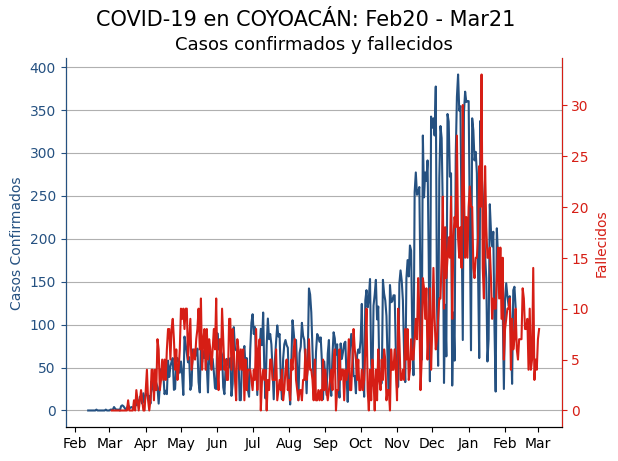

In [10]:
fig, ax = plt.subplots(dpi = 100)
# casos confirmados
ax.plot(fechasCYN, casosCYN, color = '#255181', linewidth = 1.5,
        label = 'Casos Confirmados')
ax.set_ylabel('Casos Confirmados')
ax.tick_params(colors='#255181', axis='y') 
ax.yaxis.label.set_color('#255181')
# fallecidos
axmuertos = ax.twinx()
axmuertos.plot(fechasCYNmuertos, muertosCYN, label = 'Fallecidos', 
               color = '#D61E15')
axmuertos.set_ylabel('Fallecidos')
axmuertos.tick_params(colors='#D61E15', axis='y')
axmuertos.yaxis.label.set_color('#D61E15')
# los spines del gemelo quedan arriba 
axmuertos.spines['right'].set_color('#D61E15')
axmuertos.spines['left'].set_color('#255181')

axmuertos.spines['top'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_major_locator(dates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))

fig.suptitle("COVID-19 en COYOACÁN: Feb20 - Mar21", fontsize = 15)
ax.set_title("Casos confirmados y fallecidos", fontsize = 13)
ax.grid(axis = 'y')
plt.show()